# Function and imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import scipy.io as scp
import copy
import random
from sklearn.model_selection import StratifiedKFold
import scipy
import math
from sklearn.linear_model import LinearRegression

#Machine learning libraries 
# %tensorflow_version 1.x
import tensorflow as tf
import keras as keras 
from keras import models 
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
import sklearn as skl
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import regularizers    
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras.layers import BatchNormalization

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.
C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def Normalize_Vectors(Matrix, Min, Max):

    Normalized_Matrix = np.zeros(Matrix.shape)
    for i in range(Matrix.shape[0]):
        for j in range(Matrix.shape[1]):
            Normalized_Matrix[i,j] = (Matrix[i,j]-Min)/(Max-Min)
    return Normalized_Matrix

def Vectorize_Connectivity_Matrix(Original_Matrix):
    N_Subjects = Original_Matrix.shape[2]
    N_Brain_Regions = 90
    #Lower Triangle n_elements --> (90*90/2) - 90/2 = 4005
    N_Elements_In_Vector = 4005 

    Vectorized_Matrix = np.zeros((N_Subjects, N_Elements_In_Vector)) 

    for n in range(N_Subjects):
        Counter = 0
        for i in range(N_Brain_Regions):
            for j in range(N_Brain_Regions):
                if i>j:
                    Vectorized_Matrix[n, Counter] = Original_Matrix[i,j,n]
                    Counter +=1

    return Vectorized_Matrix

def flatten_list(list_):
    new_list = []
    for i in list_:
        for j in i:
            new_list.append(j)
    return new_list

def Get_Mean_Absolute_Error(ytest, ypred):
    MAE_ = np.zeros(len(ytest), )
    for i in range(len(ytest)):
        MAE_[i] = np.abs(ytest[i]-ypred[i])
    return np.mean(MAE_)

def Performance_Scores(ytest_5folds, ypredicted_5folds):
    
    for i in range(len(ytest_5folds)):
        MAE_fold = Get_Mean_Absolute_Error(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        Corr_fold = scipy.stats.pearsonr(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        MAD_Fold = scipy.stats.median_abs_deviation(np.array(ypredicted_5folds[i]).flatten()) #Mean Absolute deviation
        R2_Fold = skl.metrics.r2_score(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        print('For fold', str(i+1), '--- MAE =', MAE_fold, '--- Corr =', Corr_fold[0], '--- p value =',Corr_fold[1], '--- MAD of prediction:', MAD_Fold, '--- R2: ', R2_Fold)

    ytest_flat = []
    ypred_flat = []
        
    for i in range(len(ytest_5folds)):
        for j in range(len(ytest_5folds[i])):
            ytest_flat.append(ytest_5folds[i][j])
            ypred_flat.append(ypredicted_5folds[i].flatten()[j])

    Total_MAE = Get_Mean_Absolute_Error(ytest_flat, ypred_flat)
    Total_Corr = scipy.stats.pearsonr(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    Total_MAD = scipy.stats.median_abs_deviation(np.array(ypred_flat).flatten()) #Mean Absolute deviation
    Total_R2 = skl.metrics.r2_score(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())


    print('For total scores, MAE =', Total_MAE, '--- Corr =', Total_Corr[0], '--- p value =',Total_Corr[1], '--- MAD of prediction:', Total_MAD, '--- R2: ', Total_R2)


# Open data & preprocessing

In [3]:
#Load data from matlab struct - turn into np array, and verify shape is correct

Path_to_Connectivity = os.path.abspath('C:/Users/Yassine/Documents/3rd Year Project/Summer Work/Code/NewStructuralConnectivity.mat')
Data = scp.loadmat(Path_to_Connectivity)

PMA = np.array(Data.get('pma'))
GA = np.array(Data.get('ga'))
Sex = np.transpose(np.array(Data.get('sex')))
Structural = np.array(Data.get('SCmu'))
N = Structural.shape[2]
Names = Data.get('sub')
Subject_ID = [x.tolist()[0][4:] for x in Names[0]]

print('Number of subjects = ' , GA.shape[0])
print('Shape of Structural Matrix : ', Structural.shape)

Number of subjects =  524
Shape of Structural Matrix :  (90, 90, 524)


## Vectorizing connectome

In [4]:
#Take lower triangle of connectivity Matrix Reshape as vector of 4005 elements
X = Vectorize_Connectivity_Matrix(Structural)

## Balance subjects on age category 

In [5]:
def Get_Equal_Density_Distribution(X, GA, PMA, Subject_ID): #This function is for balacing the distribution per age category, 
    # as described in the paper.
    
    Bins_X = []
    Bins_GA = []
    Bins_PMA = []
    Bins_Subject_ID = []
    
    
    # First, add all preterm cohort 
    for i in range(len(Subject_ID)):
        if GA[i]<37:
            
            Bins_X.append(X[i])
            Bins_GA.append(GA[i][0])
            Bins_PMA.append(PMA[i][0])
            Bins_Subject_ID.append(Subject_ID[i])

    n_preterm = len(Bins_Subject_ID) 
    
    
    # Adding term cohort
    N_Term_Per_Bins = 7 #Number of term infants per term age category. 
    
    Term_Bins = np.array([37, 38, 39, 40, 41, 42, 43])
    
    for n in range(6):
        count = 0
        for i in range(len(Subject_ID)):
            if count < N_Term_Per_Bins and GA[i]>Term_Bins[n] and GA[i]<Term_Bins[n+1]:
            
                Bins_X.append(X[i])
                Bins_GA.append(GA[i][0])
                Bins_PMA.append(PMA[i][0])
                Bins_Subject_ID.append(Subject_ID[i]) 
                 
                count = count + 1
                
    print('We have:', len(Bins_Subject_ID), 'subject in the set, including', n_preterm, 'preterm subjects')
    
    return np.array(Bins_X), np.array(Bins_GA).flatten(), np.array(Bins_PMA).flatten(), Bins_Subject_ID


In [6]:
Bins_X, Bins_GA, Bins_PMA, Bins_Subject_ID = Get_Equal_Density_Distribution(X, GA, PMA, Subject_ID)
  

We have: 145 subject in the set, including 106 preterm subjects


# Cross validation split

We do the cross validation split before entering the training loop to easily save all information of the split. This is in case we need to reproduce results later or use different methods whilst keeping the same split as described in the paper.

In [7]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)


#For saving purposes 
Train_Folds_Subjects = [] 
Test_Folds_Subjects = []

#For later use with training  
Train_Folds_Indexes = [] 
Test_Folds_Indexes = []




for train_index, test_index in skf.split(Bins_Subject_ID, np.array(Bins_GA)*0):
    
    local_train_subject_id = []
    local_test_subject_id = []
    
    for i in range(len(Bins_Subject_ID)):
        if i in train_index:
            local_train_subject_id.append(Bins_Subject_ID[i])
            
        elif i in test_index:
            local_test_subject_id.append(Bins_Subject_ID[i])
    
    #Save subject IDs of all subjects in the different folds
    Train_Folds_Subjects.append(local_train_subject_id)
    Test_Folds_Subjects.append(local_test_subject_id)
    
    #Save indexes in the connectivity matrix to assign corresponding GA
    Train_Folds_Indexes.append(train_index)
    Test_Folds_Indexes.append(test_index) 
    

# Saving fold split 
        

In [8]:
# # Saving fold split subjects and split

np.savez('Train_Fold_Subjects_GA', np.array(Train_Folds_Subjects))

np.savez('Test_Fold_Subjects_GA', np.array(Test_Folds_Subjects))

np.savez('Train_Fold_Indexes_GA', np.array(Train_Folds_Indexes))

np.savez('Test_Fold_Indexes_GA', np.array(Test_Folds_Indexes))

# DNN Training

## Model definition

In [9]:
def Get_GA_DNN_Model():
    
    inputs = Input(shape=(4005,))
    x = Activation('relu')(inputs)
    x = Dense(500)(inputs) 
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    x = Dense(250)(x) 
    x = Activation('relu')(x)
    x = Dense(250)(x) 
    x = Activation('relu')(x)
    x = Dense(100)(x)    
    x = Activation('relu')(x)
    x = Dense(100)(x)    
    x = Activation('relu')(x)
    x = Dense(50)(x)
    x = Activation('relu')(x)
    predictions = Dense(1)(x)
    model = Model(inputs=inputs, outputs=predictions)
    Adam = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer= Adam, loss='mse', metrics=['mae'])
    
    return model

## This function is to get bias in prediction from train/validation set. 
## This will be used to correct our predictions. 

def Get_Model_Bias(ytest, ypred): #Model linear correction
 
    model_error = ytest.reshape((-1,1)) - ypred.reshape((-1,1))

    #Find best fit for error as a function of age
    model = LinearRegression()
    Model = model.fit(ytest.reshape((-1,1)), model_error.reshape((-1,1)))
    coeff = Model.coef_
    intercept = Model.intercept_
    Parameters = [coeff, intercept]

    return Parameters


## Training

In [10]:
DNN_Correction_Parameters = []
DNN_GA_Models = []
Corrected_Predictions_DNN = []
Test_Output_5_Folds = []
DNN_Normalization_Values_GA = []

for i in range(n_folds):

    # Get data from the cross validation 
    Non_Normalized_Training_Input = Bins_X[Train_Folds_Indexes[i]]
    Non_Normalized_Testing_Input = Bins_X[Test_Folds_Indexes[i]]
    
    Min_Training_Input = np.min(Non_Normalized_Training_Input)
    Max_Training_Input = np.max(Non_Normalized_Training_Input)

    DNN_Normalization_Values_GA.append([Min_Training_Input, Max_Training_Input]) #Saving normalization values
    
    Training_Input = Normalize_Vectors(Non_Normalized_Training_Input, Min_Training_Input, \
                              Max_Training_Input)
    
    Testing_Input = Normalize_Vectors(Non_Normalized_Testing_Input, Min_Training_Input, \
                              Max_Training_Input)

    Training_Output = Bins_GA[Train_Folds_Indexes[i]]
    Testing_Output = Bins_GA[Test_Folds_Indexes[i]]
    
    
    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 6 or Corr_Val < 0.75 or MAE_Val > 2: #Only save model if performance on validation is good enough
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_GA_DNN = None 
        Local_Model_GA_DNN = Get_GA_DNN_Model()
        Training_History = Local_Model_GA_DNN.fit(xtrain, ytrain, epochs = 80, batch_size = 18, verbose=0, validation_data = (xval, yval))

        Validation_Preds = Local_Model_GA_DNN.predict(xval).flatten()

        
        MAE_Val = Local_Model_GA_DNN.evaluate(xval,yval)[1]
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(np.abs(Validation_Preds-yval)) 
        
        Local_Parameters = Get_Model_Bias(yval, Validation_Preds)
        
    ### Exited while loop - trained model is a keeper!
    print('fold', i+1, 'successfully trained')
    
    #Compute prediction on test set
    Test_Predctions_DNN = Local_Model_GA_DNN.predict(Testing_Input).flatten()
    Test_Predctions_DNN_Bias_Corrected = Test_Predctions_DNN + Test_Predctions_DNN*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions into variables
    DNN_GA_Models.append(Local_Model_GA_DNN)
    DNN_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_DNN.append(Test_Predctions_DNN_Bias_Corrected)
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output.flatten(), Test_Predctions_DNN_Bias_Corrected.flatten())
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_DNN_Bias_Corrected).flatten())
    
    
print('\nTraining successful on all folds')   
    

fold 1 successfully trained
fold 2 successfully trained
fold 3 successfully trained
fold 4 successfully trained
fold 5 successfully trained

Training successful on all folds


## Saving models and predictions

In [11]:
# Save models locally
for i in range(5):
    loc_model = DNN_GA_Models[i]
    loc_model.save(str('GA_DNN_Model' + str(i) + '.h5'))
    

#Save bias paramters
np.savez('Bias_Parameters_GA_DNN', np.array(DNN_Correction_Parameters))

#Save normalization parameters paramters
np.savez('DNN_Normalization_Values_GA', np.array(DNN_Normalization_Values_GA))

#Save True GA
np.savez('Test_Output_5_Folds_GA', np.array(Test_Output_5_Folds))

#Save Predicted GA
np.savez('Corrected_Predictions_DNN_5_Folds_GA', np.array(Corrected_Predictions_DNN))

# Visualizing DNN results and performance

In [12]:
## Loading data
import pickle
Test_Fold_Subjects = np.load('GA_Files/DNN/Test_Output_5_Folds_GA.npz')['arr_0']
Predicted_Fold_Subjects = np.load('GA_Files/DNN/Corrected_Predictions_DNN_5_Folds_GA.npz')['arr_0']

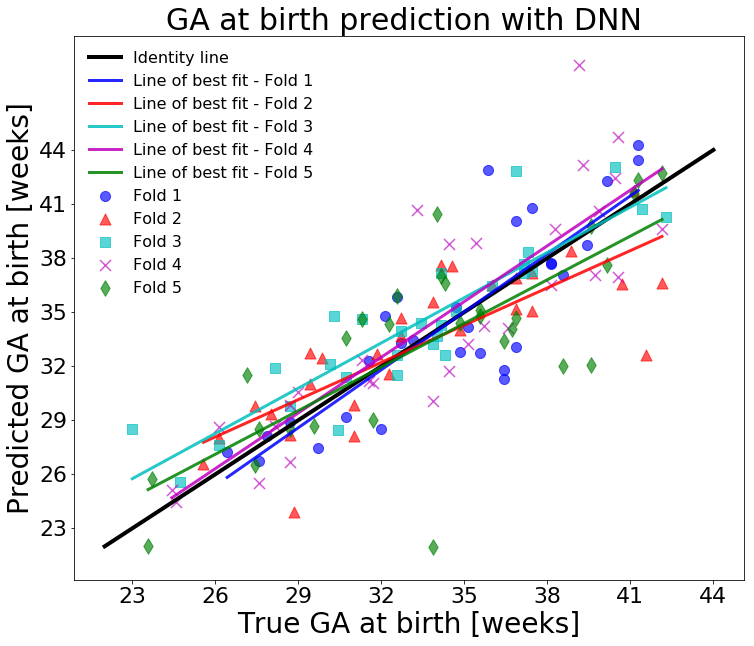

In [13]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([22, 44],[22, 44], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_GA = Test_Fold_Subjects[i].flatten()
    Predicted_GA = Predicted_Fold_Subjects[i].flatten()
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_GA).reshape(-1, 1), np.array(Predicted_GA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_GA), max(True_GA), 5).flatten()
    yyy = coeff*xxx + intercept
    
    if i == 0:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 102)
    elif i ==2:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 112)
    else:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 122)
    plt.plot(xxx, yyy.flatten(), color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3, alpha = 0.85)
    plt.xticks(np.arange(23,46, 3), fontsize = 22)
    plt.yticks(np.arange(23,46, 3), fontsize = 22)
    plt.xlabel('True GA at birth [weeks]', fontsize=28)
    plt.ylabel('Predicted GA at birth [weeks]',fontsize=28)
    plt.title('GA at birth prediction with DNN ', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('DNN_GA.png', dpi=250)
    

In [14]:
Performance_Scores(Test_Fold_Subjects, Predicted_Fold_Subjects)

For fold 1 --- MAE = 2.1003557264045742 --- Corr = 0.8536337474373479 --- p value = 3.956608125373806e-09 --- MAD of prediction: 4.266833343496678 --- R2:  0.5668595631257599
For fold 2 --- MAE = 2.1142610068107883 --- Corr = 0.7999879685569837 --- p value = 1.9119473768475534e-07 --- MAD of prediction: 2.9360709567661587 --- R2:  0.6332153364357217
For fold 3 --- MAE = 1.663179686281034 --- Corr = 0.8957517684370984 --- p value = 5.2530143027598426e-11 --- MAD of prediction: 2.8554600200051468 --- R2:  0.7451904093246079
For fold 4 --- MAE = 2.4973280440775945 --- Corr = 0.8611163033205073 --- p value = 2.0409302004323946e-09 --- MAD of prediction: 4.726626789022845 --- R2:  0.6171715693273416
For fold 5 --- MAE = 2.6632289018976745 --- Corr = 0.7543953801742862 --- p value = 2.279454527605827e-06 --- MAD of prediction: 2.819920710325704 --- R2:  0.4633599472225094
For total scores, MAE = 2.2076706730943334 --- Corr = 0.8195624717822846 --- p value = 2.1061448044821795e-36 --- MAD of 

# Random Forest Traning

In [15]:
#We use same splits as the DNN training

#This is all using same methods and ideas as with the DNN training


RF_Correction_Parameters = []
RF_GA_Models = []
Corrected_Predictions_RF = []
Test_Output_5_Folds = []
RF_Normalization_Values_GA = []


for i in range(n_folds):

    # Get data from the cross validation 
    Non_Normalized_Training_Input = Bins_X[Train_Folds_Indexes[i]]
    Non_Normalized_Testing_Input = Bins_X[Test_Folds_Indexes[i]]
    
    Min_Training_Input = np.min(Non_Normalized_Training_Input)
    Max_Training_Input = np.max(Non_Normalized_Training_Input)

    RF_Normalization_Values_GA.append([Min_Training_Input, Max_Training_Input]) #Saving normalization values
    
    Training_Input = Normalize_Vectors(Non_Normalized_Training_Input, Min_Training_Input, \
                              Max_Training_Input)
    
    Testing_Input = Normalize_Vectors(Non_Normalized_Testing_Input, Min_Training_Input, \
                              Max_Training_Input)

    Training_Output = Bins_GA[Train_Folds_Indexes[i]]
    Testing_Output = Bins_GA[Test_Folds_Indexes[i]]
    
    
    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 7 or Corr_Val < 0.75 or MAE_Val > 2.3:
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_GA_RF = None 
        Local_Model_GA_RF = RandomForestRegressor(max_depth= 40,max_features = 3001,
                        n_estimators= 40,
                        random_state=42)
        Local_Model_GA_RF.fit(xtrain, ytrain)
        
        
        Validation_Preds = Local_Model_GA_RF.predict(xval)
        Training_Preds = Local_Model_GA_RF.predict(xval)
        
    
        MAE_Val = Get_Mean_Absolute_Error(Validation_Preds, yval)
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(Validation_Preds-yval) 
        
        Training_Preds = Local_Model_GA_RF.predict(xtrain)
        Local_Parameters = Get_Model_Bias(ytrain, Training_Preds)
        
        Both_Predictions = np.hstack((Training_Preds, Validation_Preds))
        Both_Ys = np.hstack((ytrain.flatten(), yval.flatten()))
        
        Local_Parameters = Get_Model_Bias(Both_Ys.reshape(-1, 1), Both_Predictions.reshape(-1, 1))
        
        
    #Exited while loop - trained model is a keeper!
    print('fold', i+1, 'successfully trained')
    
    #Compute prediction on test set
    Test_Predctions_RF = Local_Model_GA_RF.predict(Testing_Input)
    Test_Predctions_RF_Bias_Corrected = Test_Predctions_RF + Test_Predctions_RF*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions 
    RF_GA_Models.append(Local_Model_GA_RF)
    RF_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_RF.append(Test_Predctions_RF_Bias_Corrected[0])
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output, Test_Predctions_RF_Bias_Corrected[0])
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_RF_Bias_Corrected[0]).flatten())
    
    
plt.show()

    
print('Training successful done on all folds')   
    

fold 1 successfully trained
fold 2 successfully trained
fold 3 successfully trained
fold 4 successfully trained
fold 5 successfully trained
Training successful done on all folds


## Save models and predictions

In [16]:
#Save models locally
for i in range(5):
    loc_model = RF_GA_Models[i]
    with open(str('GA_RF_Model' + str(i) + '.pkl'), 'wb') as f:  
        pickle.dump(loc_model, f) 
    

#Save bias paramters
np.savez('Bias_Parameters_GA_RF', np.array(RF_Correction_Parameters))

#Save normalization paramters
np.savez('Normalization_Parameters_GA_RF', np.array(RF_Normalization_Values_GA))

#Save Predicted GA
np.savez('Corrected_Predictions_RF_5_Folds_GA', np.array(Corrected_Predictions_RF))

# RF visualization

In [17]:
## Loading data
import pickle
Test_Fold_Subjects_RF = np.load('GA_Files/RF/Test_Output_5_Folds_GA.npz')['arr_0']
Predicted_Fold_Subjects_RF = np.load('GA_Files/RF/Corrected_Predictions_RF_5_Folds_GA.npz')['arr_0']

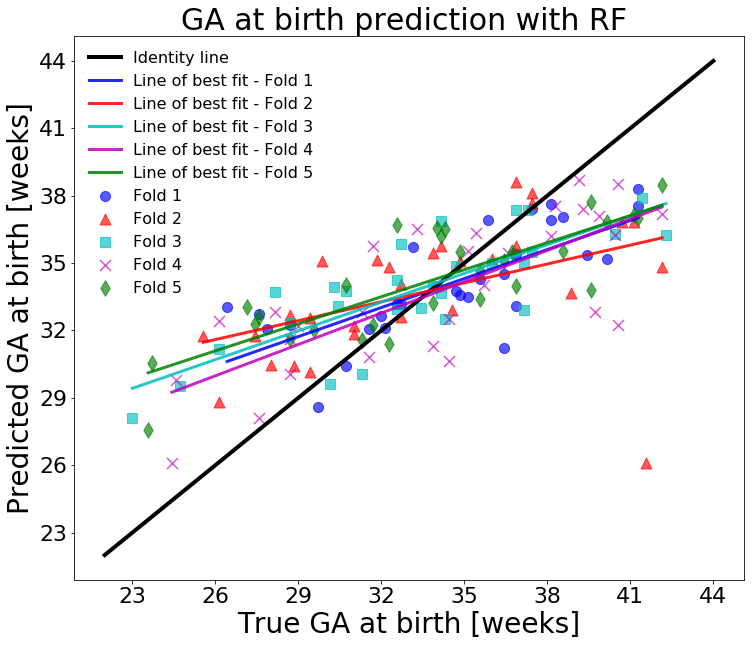

In [18]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([22, 44],[22, 44], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_GA = Test_Fold_Subjects_RF[i].flatten()
    Predicted_GA = Predicted_Fold_Subjects_RF[i].flatten()
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_GA).reshape(-1, 1), np.array(Predicted_GA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_GA), max(True_GA), 5).flatten()
    yyy = coeff*xxx + intercept
    
    if i == 0:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 102)
    elif i ==2:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 112)
    else:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 122)
    plt.plot(xxx, yyy.flatten(), color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3, alpha = 0.85)
    plt.xticks(np.arange(23,46, 3), fontsize = 22)
    plt.yticks(np.arange(23,46, 3), fontsize = 22)
    plt.xlabel('True GA at birth [weeks]', fontsize=28)
    plt.ylabel('Predicted GA at birth [weeks]',fontsize=28)
    plt.title('GA at birth prediction with RF ', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('RF_GA.png', dpi=250)
    

In [19]:
Performance_Scores(Test_Fold_Subjects_RF, Predicted_Fold_Subjects_RF)

For fold 1 --- MAE = 2.185871193037963 --- Corr = 0.7436421389273733 --- p value = 3.7894050165081017e-06 --- MAD of prediction: 1.514822155640509 --- R2:  0.5141984170982001
For fold 2 --- MAE = 2.9506498337865 --- Corr = 0.4615256032011609 --- p value = 0.011730323582598037 --- MAD of prediction: 1.6619029781203665 --- R2:  0.18982664416741046
For fold 3 --- MAE = 2.3990667371961156 --- Corr = 0.8010970949448035 --- p value = 1.7862530180293994e-07 --- MAD of prediction: 1.4131570838680432 --- R2:  0.557117997429717
For fold 4 --- MAE = 2.829364514653312 --- Corr = 0.759872129906306 --- p value = 1.7421454496983476e-06 --- MAD of prediction: 2.756004970116166 --- R2:  0.5512379069508037
For fold 5 --- MAE = 2.883485945514938 --- Corr = 0.8186908519026455 --- p value = 5.7204560980738005e-08 --- MAD of prediction: 1.996552745761754 --- R2:  0.5561500261220639
For total scores, MAE = 2.6496876448377655 --- Corr = 0.7088400002712283 --- p value = 1.9661399938166033e-23 --- MAD of predic